# Programa Ingenias+ Data Science

## Objetivo del notebook

El objetivo de este notebook es aplicar y comparar técnicas de aprendizaje no supervisado, tanto de clustering como de reducción de dimensionalidad, para identificar patrones y estructuras subyacentes en los datos.

Las columnas de características que se utilizarán en el notebook se detallan a continuación.


## Importación de archivos y librerías

In [78]:
# Imports de librerías y funciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, pairwise_distances, silhouette_score, silhouette_samples
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from utils.codificaciones import *
from utils.funcions import *

In [3]:
# Importar el csv
friesgo_raw = pd.read_csv('datasets/friesgo_analisis.csv')

In [4]:
friesgo_raw.shape

(29224, 43)

## Preprocesado

### Identificación de variables

In [5]:
# Copiar el dataframe
friesgo_cod = friesgo_raw.copy()

In [6]:
# Filas y columnas
friesgo_cod.shape

(29224, 43)

In [7]:
# Columnas presentes
friesgo_cod.columns

Index(['cant_tipos_tabaco', 'es_diabetico', 'cod_provincia',
       'ansiedad_depresion', 'fumado_100_cigarrillos',
       'af_intensa_veces_por_semana', 'tiempo_sentado_min_por_dia',
       'submuestra', 'colesterol_alto', 'ultima_medicion_glucemia',
       'condicion_fumador', 'dolor_malestar_general', 'salud_actual',
       'medido_colesterol', 'cobertura_salud', 'ranking_dieta',
       'capacidad_actividades_cotidianas', 'tamanio_aglomerado',
       'media_fv_diaria', 'nivel_educ', 'edad', 'diagnostico_cosanguineos',
       'tipo_bebida', 'presion_arterial_elevada',
       'af_moderada_veces_por_semana', 'mantiene_ha_alta',
       'nivel_actividad_fisica', 'condicion_actividad',
       'capacidad_cuidado_personal', 'peso_autoreportado_kg', 'freq_cons_alc',
       'imc_autoreportado', 'consumo_sal', 'caminata_veces_por_semana',
       'situacion_conyugal', 'sexo', 'barreras_actividad_fisica',
       'nivel_de_movilidad', 'imc_categorias_autoreportado',
       'altura_autoreportado_c

### Evaluación y procesamiento de nulos

In [8]:
calcular_nulos_y_porcentaje(friesgo_cod)

,Nulos,Porcentaje
cant_tipos_tabaco,0,0.0%
es_diabetico,0,0.0%
cod_provincia,0,0.0%
ansiedad_depresion,0,0.0%
fumado_100_cigarrillos,0,0.0%
af_intensa_veces_por_semana,0,0.0%
tiempo_sentado_min_por_dia,1110,3.8%
submuestra,0,0.0%
colesterol_alto,0,0.0%
ultima_medicion_glucemia,0,0.0%


In [9]:
# Remover columnas con > 50% de nulos
friesgo_cod.drop(columns=['tipo_bebida', 'tratamiento_medico_col'], inplace=True)

In [10]:
friesgo_cod.shape

(29224, 41)

### Codificación de columnas

In [11]:
# Codificación de columnas
le = LabelEncoder()
for columnas in friesgo_cod:
    friesgo_cod[columnas] = le.fit_transform(friesgo_cod[columnas])

In [12]:
# Evaluar que no haya pérdida de filas y/o columnas por la codificación
friesgo_cod.shape

(29224, 41)

## Reducción de dimensionalidad

### Paso 1 : Permutation Importance

Se aplica un algoritmo de clasificación Random Forest para evaluar la importancia de las características del dataset. Esto nos permite identificar las columnas más relevantes, lo que facilita la reducción de dimensionalidad al eliminar aquellas con menor relevancia.

In [13]:
# Separar los conjuntos para entrenamiento y testeo
y = friesgo_cod['mantiene_ha_alta']
X = friesgo_cod.drop(columns=['mantiene_ha_alta'])
X_train_pi, X_test_pi, y_train_pi, y_test_pi = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
# Entrenar el modelo para tener los parametros de accuracy de base
modelo = RandomForestClassifier(random_state=42,criterion= 'gini', n_estimators=200, max_depth=8)

# Ajustar el modelo
modelo.fit(X_train_pi, y_train_pi)

RandomForestClassifier(max_depth=8, n_estimators=200, random_state=42)

In [15]:
# Calcular el acurracy base
y_pred_pi = modelo.predict(X_test_pi)
acc = accuracy_score(y_test_pi, y_pred_pi)
acc

0.6641195255474452

In [16]:
# Calcular Permutation Importance
perm = permutation_importance(modelo, X_test_pi, y_test_pi,random_state=1)

In [17]:
# Ordenar las características por importancia promedio
indices = np.argsort(perm.importances_mean)  # Orden ascendente
features = X_test_pi.columns[indices]
importances = perm.importances_mean[indices]
importances_std = perm.importances_std[indices]

In [18]:
features

Index(['imc_categorias_autoreportado', 'capacidad_actividades_cotidianas',
       'tiempo_sentado_min_por_dia', 'nivel_educ', 'periodicidad_fumador',
       'barreras_actividad_fisica', 'tamanio_aglomerado', 'condicion_fumador',
       'ranking_dieta', 'nivel_actividad_fisica', 'diagnostico_cosanguineos',
       'ansiedad_depresion', 'cobertura_salud', 'condicion_actividad',
       'imc_categoria', 'capacidad_cuidado_personal',
       'af_moderada_veces_por_semana', 'cant_tipos_tabaco',
       'fumado_100_cigarrillos', 'caminata_veces_por_semana',
       'media_fv_diaria', 'situacion_conyugal', 'dolor_malestar_general',
       'altura_autoreportado_cm', 'submuestra', 'af_intensa_veces_por_semana',
       'freq_cons_alc', 'ultima_medicion_glucemia', 'cod_provincia',
       'peso_autoreportado_kg', 'sexo', 'nivel_de_movilidad', 'es_diabetico',
       'imc_autoreportado', 'medido_colesterol', 'presion_arterial_elevada',
       'consumo_sal', 'colesterol_alto', 'salud_actual', 'edad'],
   

In [19]:
importances

array([-1.48266423e-03, -1.32299270e-03, -7.52737226e-04, -7.29927007e-04,
       -7.07116788e-04, -6.61496350e-04, -5.01824818e-04, -3.42153285e-04,
       -3.19343066e-04, -2.96532847e-04, -2.73722628e-04, -2.28102190e-04,
       -1.82481752e-04, -1.36861314e-04, -1.36861314e-04, -4.56204380e-05,
       -2.28102190e-05, -2.28102190e-05,  0.00000000e+00,  6.84306569e-05,
        9.12408759e-05,  1.14051095e-04,  1.36861314e-04,  1.36861314e-04,
        1.36861314e-04,  2.05291971e-04,  3.42153285e-04,  3.42153285e-04,
        4.10583942e-04,  4.56204380e-04,  5.70255474e-04,  7.29927007e-04,
        9.58029197e-04,  2.21259124e-03,  2.48631387e-03,  2.87408759e-03,
        4.49361314e-03,  6.04470803e-03,  8.09762774e-03,  3.69069343e-02])

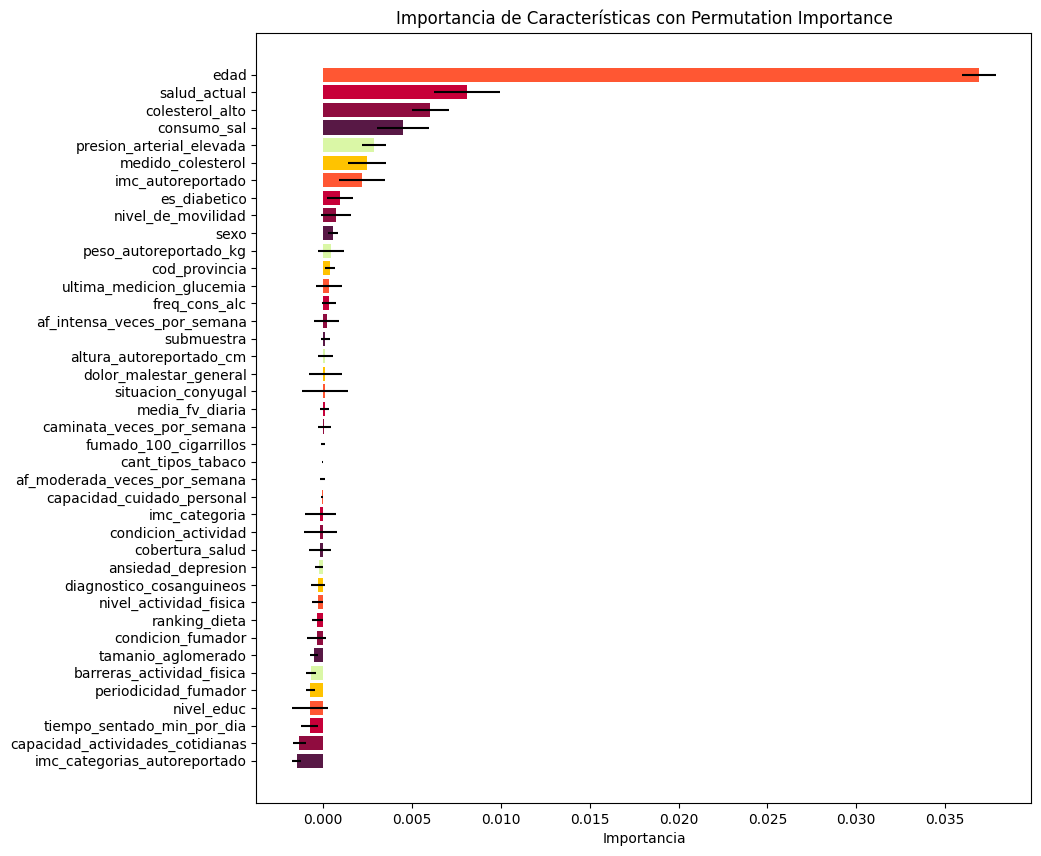

In [20]:
# Crear el gráfico de barras
plt.figure(figsize=(10, 10))
plt.barh(features, importances, xerr=importances_std, align='center',color=['#581845','#900C3F','#C70039','#FF5733','#FFC300','#DAF7A6'])
plt.xlabel('Importancia')
plt.title('Importancia de Características con Permutation Importance')
plt.show()

Se seleccionarán las 10 características principales, que son aquellas que más contribuyen a la precisión del modelo. 

In [21]:
friesgo_reducida = friesgo_cod.filter(items=[
    'edad',
    'salud_actual',
    'colesterol_alto',
    'consumo_sal',
    'presion_arterial_elevada',
    'medido_colesterol',
    'imc_autoreportado_kg',
    'es_diabetico',
    'nivel_de_movilidad',
    'sexo',
])

Este nuevo DataFrame servirá de entrada para los siguientes algoritmos no supervisados.

### Paso 2: PCA

#### Estandarizar datos

PCA es sensible a la escala de las columnas. La estandarización asegura que cada característica contribuya igualmente al análisis.

In [22]:
# Estandarización de los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(friesgo_reducida)
scaled_data

array([[-0.80262659,  0.20926025,  0.46683254, ...,  0.37107188,
        -0.38330409, -1.14927744],
       [ 1.0254472 , -1.87223111, -1.82067823, ...,  0.37107188,
        -0.38330409,  0.87011192],
       [-0.74723041, -0.83148543,  0.46683254, ...,  0.37107188,
        -0.38330409,  0.87011192],
       ...,
       [ 1.52401278,  0.20926025, -1.82067823, ...,  0.37107188,
        -0.38330409,  0.87011192],
       [-0.13787248,  0.20926025,  0.46683254, ..., -2.49095101,
        -0.38330409,  0.87011192],
       [-0.35945718,  1.25000594,  0.46683254, ..., -2.49095101,
        -0.38330409,  0.87011192]])

#### Evaluar el número óptimo de componentes para PCA

Para conservar el 80% de información al aplicar PCA, hay que seleccionar el número de componentes principales que en conjunto expliquen al menos el 95% de la varianza total.

In [23]:
pca = PCA(n_components = 0.80)
pca_data = pca.fit_transform(scaled_data)
n_components = pca.n_components_

# Ver el número de componentes seleccionados automáticamente
print(f"Número de componentes seleccionados: {n_components}")

Número de componentes seleccionados: 7


#### Aplicar PCA 

Se aplica PCA con el número de componentes principales calculado con anterioridad.

In [24]:
# Aplicar PCA con el número óptimo de componentes
pca_opt = PCA(n_components = n_components)
pca_opt_data = pca_opt.fit_transform(scaled_data)

# Convertir a DataFrame para facilitar el manejo
pca_df = pd.DataFrame(data = pca_opt_data, columns = [f'PC{i+1}' for i in range(n_components)])
pca_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,-0.165309,0.364004,-1.835499,1.197803,-0.055517,-0.155620,-0.334023
1,0.508595,-2.543623,0.255155,0.212306,-0.338159,0.618653,-0.051432
2,-1.364998,-1.036843,1.276457,-1.286142,0.470775,0.921527,0.871006
3,1.015854,-1.462214,0.805133,-0.977688,0.045681,1.071606,-0.700025
4,-0.904043,-0.407459,-0.082161,-0.391612,-1.112086,-0.471958,-0.424371
...,...,...,...,...,...,...,...
29219,-0.611004,-0.811814,1.220352,0.262887,0.127169,-0.209701,-0.310046
29220,1.119542,-0.739746,-1.430794,-0.429208,-0.735011,0.667676,-0.992916
29221,1.808449,-0.687430,-0.955223,0.626937,1.074558,1.408907,-0.570870
29222,0.493110,-0.697374,0.993657,-1.492720,1.094235,-1.633929,1.201303


#### Visualizar la varianza explicada 

Permite ver cómo cada componente principal contribuye a la varianza total y cómo se acumula la varianza explicada.

In [25]:
# Obtener la varianza explicada por cada componente
explained_variance = pca.explained_variance_ratio_

# Imprimir la varianza explicada por cada componente principal
print('Varianza explicada')
for i in range(n_components):
    print('PC{}: {}'.format(i+1, pca.explained_variance_ratio_[i]))

Varianza explicada
PC1: 0.242431519628665
PC2: 0.12710934083659922
PC3: 0.11460352544015608
PC4: 0.10951112519919237
PC5: 0.10403648763065204
PC6: 0.09580703940340121
PC7: 0.07908846524682467


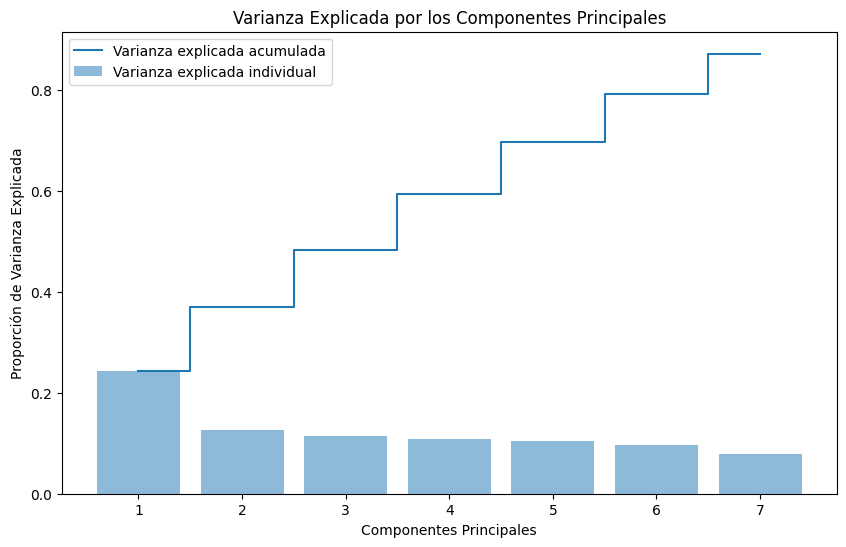

In [26]:
# Visualización de la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Varianza explicada individual')
plt.step(range(1, len(np.cumsum(explained_variance)) + 1), np.cumsum(explained_variance), where='mid', label='Varianza explicada acumulada')
plt.xlabel('Componentes Principales')
plt.ylabel('Proporción de Varianza Explicada')
plt.title('Varianza Explicada por los Componentes Principales')
plt.legend(loc='best')
plt.show()

In [27]:
def plot_3d_scatter(ax, data, view_angle=(90, 30)):
    """
    Función para crear un scatterplot 3D dado un subplot y datos.
    
    Parameters:
    - ax: El objeto Axes3D donde se dibujará el scatterplot.
    - data: DataFrame que contiene las columnas 'PC1', 'PC2', 'PC3', y 'PC4'.
    - view_angle: Tuple que contiene los ángulos de elevación y azimut (elev, azim).
    """
    '''
    group1 = data[data['PC4'] == 0]
    group2 = data[data['PC4'] == 1]
    group3 = data[data['PC4'] == 2]
    
    # Graficar los tres grupos con diferentes colores y marcadores
   
    ax.scatter(group1['PC1'], group1['PC2'], group1['PC3'], color='r', label='Cluster 0', marker='o', alpha=0.7)
    ax.scatter(group2['PC1'], group2['PC2'], group2['PC3'], color='g', label='Cluster 1', marker='^', alpha=0.7)
    ax.scatter(group3['PC1'], group3['PC2'], group3['PC3'], color='b', label='Cluster 2', marker='s', alpha=0.7)
'''
    ax.scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], c=pca_df['PC4'],
                     cmap='tab20', marker='o', alpha=0.7)
    
    # Etiquetas de los ejes
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    
    # Configurar la vista
    ax.view_init(elev=view_angle[0], azim=view_angle[1])
    
    # Título del gráfico con el ángulo actual
    ax.set_title(f'Vista: Elev={view_angle[0]}, Azim={view_angle[1]}')


C:\Users\Biank\AppData\Local\Temp\ipykernel_3348\563944730.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))


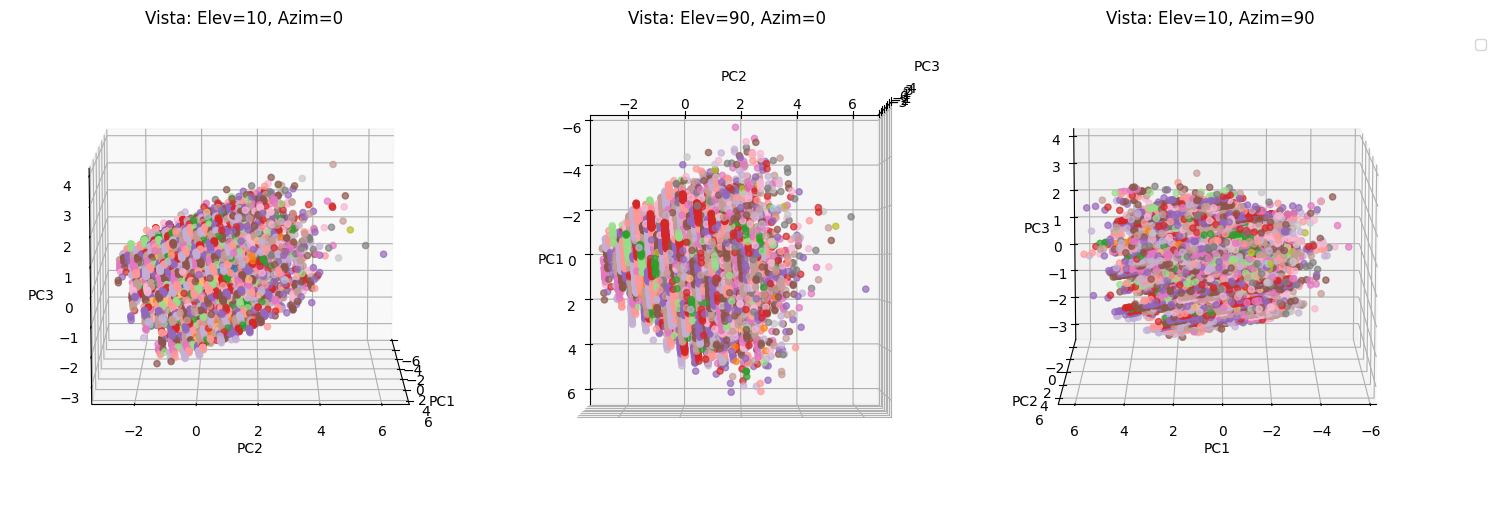

In [28]:
# Configurar la figura con tres subplots
fig = plt.figure(figsize=(15, 5))

# Definir los ángulos para cada vista
angles = [(10, 0), (90, 0), (10, 90)]

# Crear subplots con diferentes vistas usando la función
for i, angle in enumerate(angles):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    plot_3d_scatter(ax, pca_df, view_angle=angle)

# Añadir una leyenda fuera de los subplots
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Mostrar el gráfico
plt.tight_layout()
plt.show()


## Análisis de modelos

### Modelo 1: K-Means

Para la aplicacion de este modelo se seguiran los siguientes pasos:

+ 1 : Busqueda de posibles outliers en la salida del PCA ()
+ 2 : Calculo de la cantidad optima de clusters mediante la tecnica visual del "codo"
+ 3 : Calculo de la cantidad optima de cluster mediante metodo Silhouette Score
+ 4 : Aplicacion del modelo y graficado de clusters



#### Paso 1

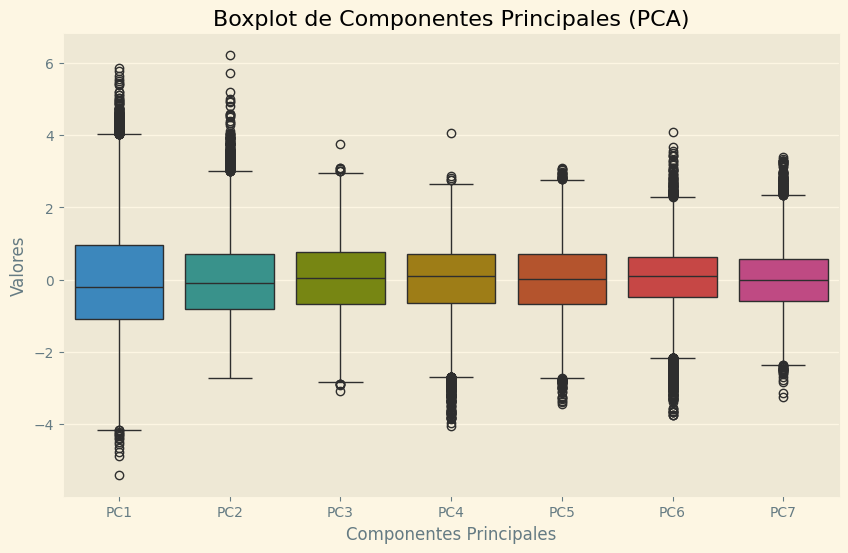

In [35]:
# analisis de los valores para deteccion de outliers en las columnas a utilizar
# Crear un boxplot para cada componente principal
plt.figure(figsize=(10, 6))
sns.boxplot(data=pca_df)
plt.title('Boxplot de Componentes Principales (PCA)')
plt.xlabel('Componentes Principales')
plt.ylabel('Valores')
plt.show()

In [38]:
# Creamos una copia para preservar los datos originales
filtered_df = pca_df.copy()

for col in filtered_df.columns:
    Q1 = filtered_df[col].quantile(0.25)
    Q3 = filtered_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filtrar las filas que están dentro de los límites
    filtered_df = filtered_df[(filtered_df[col] >= lower_bound) & (filtered_df[col] <= upper_bound)]

print(f"Datos originales: {pca_df.shape[0]} registros")
print(f"Datos después de eliminar outliers: {filtered_df.shape[0]} registros")


Datos originales: 29224 registros
Datos después de eliminar outliers: 27435 registros


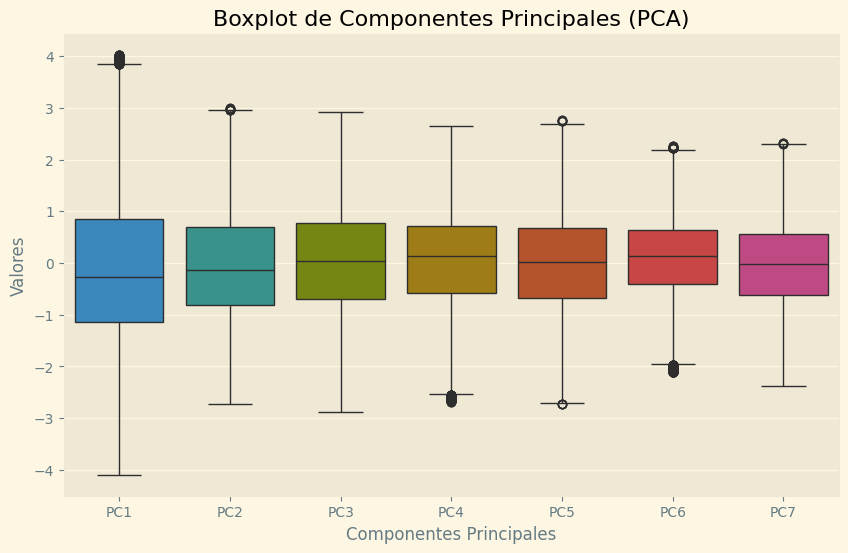

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df)
plt.title('Boxplot de Componentes Principales (PCA)')
plt.xlabel('Componentes Principales')
plt.ylabel('Valores')
plt.show()

In [40]:
filtered_df.shape

(27435, 7)

En el analisis exploratorio, en el grafico de scatter pueden observase algunos puntos mas dispersos, lo que en un principio podrian ser outliers, al realizar los boxplots correspondientes se confirmo que habia presencia de outliers en un 0.85% por lo que fueron eliminados/filtrados para aumentar la efectividad del algoritmo k-means.

#### Paso 2

In [70]:
# Test codo pca_df reducida
inertias = []
k_range = range(1,15) 

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=20, max_iter=500, random_state=42)
    kmeans.fit(filtered_df) # aplicar kmeans a mi dataframe
    inertias.append(kmeans.inertia_)

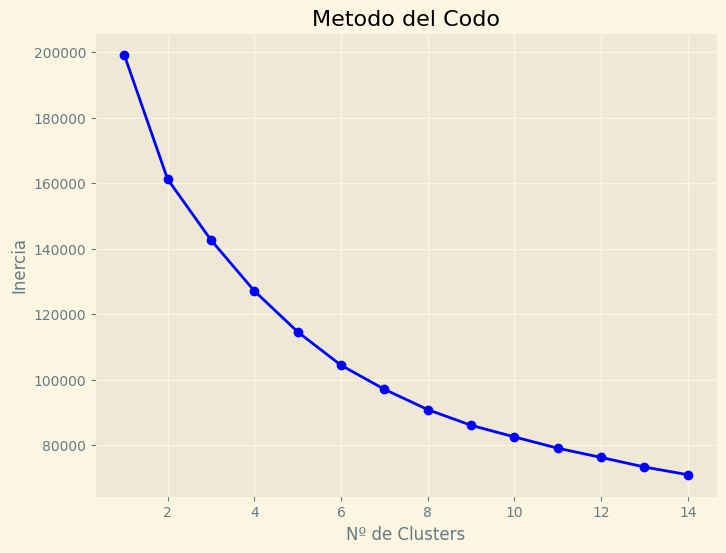

In [71]:
# Graficar el metodo del codo
plt.figure(figsize=(8, 6))
plt.style.use('Solarize_Light2')
plt.plot(k_range, inertias, 'bo-')
plt.xlabel('Nº de Clusters')
plt.ylabel('Inercia')
plt.title('Metodo del Codo')
plt.show()

Del grafico puede observarse que la inercia comienza a disminuir de manera menos pronunciada alrededor de los 5 a 7 clusters, el codo no es muy pronunciado, por lo que se utilizaran esos valores de cluster (5,6,7) y se evaluaran con Silhouette Score para determinar el optimo.

#### Paso 3

Para n_clusters = 5, el Silhouette Score promedio es: 0.31


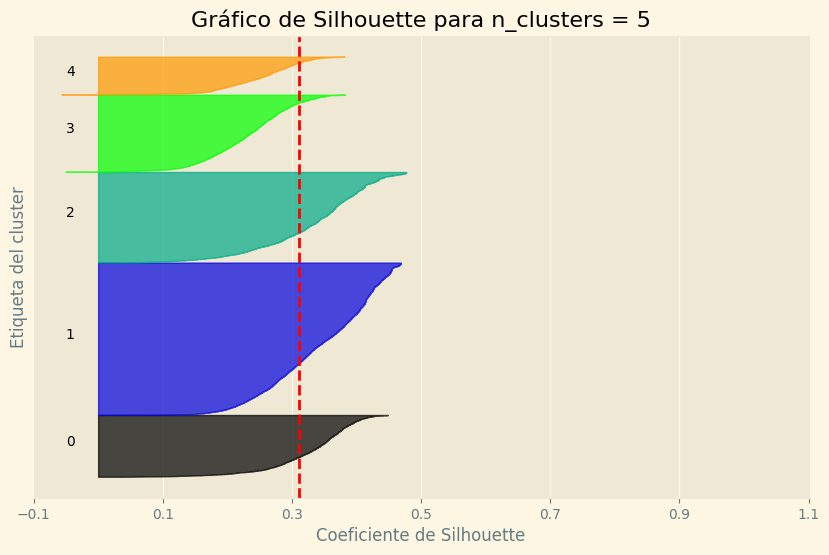

Para n_clusters = 6, el Silhouette Score promedio es: 0.25


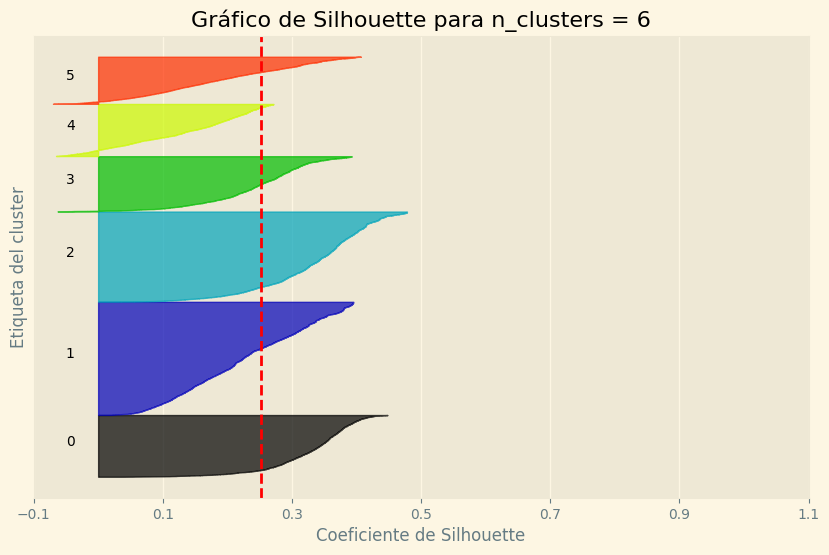

Para n_clusters = 7, el Silhouette Score promedio es: 0.26


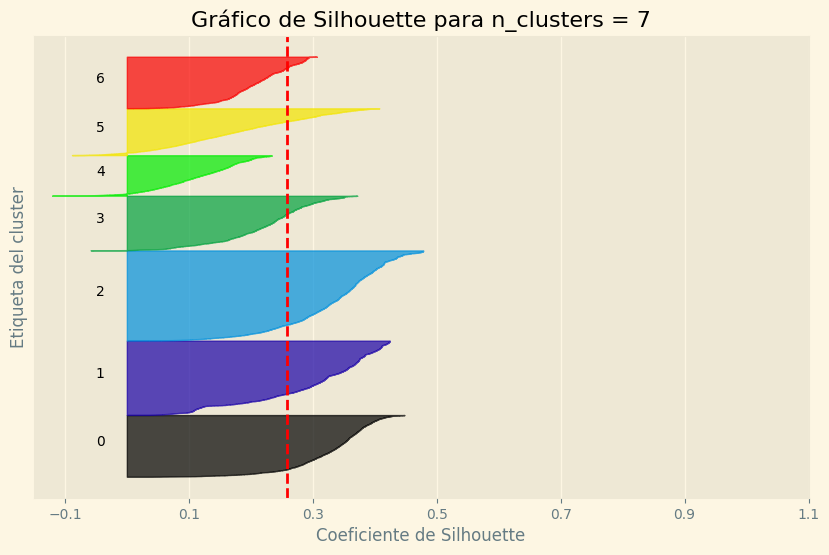

In [122]:
range_n_clusters = [5, 6, 7]  # Numeros de clusters a probar

for n_clusters in range_n_clusters:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Aplicar K-means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
    cluster_labels = kmeans.fit_predict(filtered_df)
    
    # Calcular el Silhouette Score promedio
    silhouette_avg = silhouette_score(filtered_df, cluster_labels)
    print(f"Para n_clusters = {n_clusters}, el Silhouette Score promedio es: {silhouette_avg:.2f}")
    
    # Calcular los Silhouette Scores para cada punto
    sample_silhouette_values = silhouette_samples(filtered_df, cluster_labels)
    
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                         facecolor=color, edgecolor=color, alpha=0.7)
        
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        
        y_lower = y_upper + 10  
    
    ax.set_title(f"Grafico de Silhouette {n_clusters} clusters")
    ax.set_xlabel("Coeficiente de Silhouette")
    ax.set_ylabel("")
    
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_yticks([])  
    ax.set_xticks(np.arange(-0.1, 1.1, 0.2))
    
    plt.show()

#### Paso 4

In [123]:
# Aplicar modelo
cluster =  KMeans(n_clusters=5, init='k-means++', random_state=42)
cluster.fit(filtered_df)

KMeans(n_clusters=5, random_state=42)

In [124]:
# Agregar las etiquetas generadas por el algoritmo al dataframe
filtered_df['cluster_label'] = cluster.labels_
filtered_df.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,cluster_label
0,-0.165309,0.364004,-1.835499,1.197803,-0.055517,-0.155620,-0.334023,1
1,0.508595,-2.543623,0.255155,0.212306,-0.338159,0.618653,-0.051432,1
2,-1.364998,-1.036843,1.276457,-1.286142,0.470775,0.921527,0.871006,0
3,1.015854,-1.462214,0.805133,-0.977688,0.045681,1.071606,-0.700025,3
4,-0.904043,-0.407459,-0.082161,-0.391612,-1.112086,-0.471958,-0.424371,1


In [119]:
# Graficar los clusters


SyntaxError: invalid syntax (905710932.py, line 1)

### Modelo 2: DBSCAN

#### Análisis Exploratorio
A partir del scatterplot anterior, donde pueden visualizarse 4 grupos, se tratará de determinar los valores óptimos de `eps` y `min_samples` para el algoritmo DBSCAN.

In [ ]:
# Configurar y aplicar DBSCAN
eps = 0.5  # Ajusta este valor según el dataset
min_samples = 1000  # Ajusta este valor según el dataset
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clusters = dbscan.fit_predict(pca_df)

# Añadir los clusters al DataFrame PCA
pca_data = pd.DataFrame(data=pca_df, columns=[f'PC{i+1}' for i in range(9)])
pca_data['Cluster'] = clusters

C:\Users\Biank\AppData\Local\Temp\ipykernel_3348\1629678819.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette='viridis')


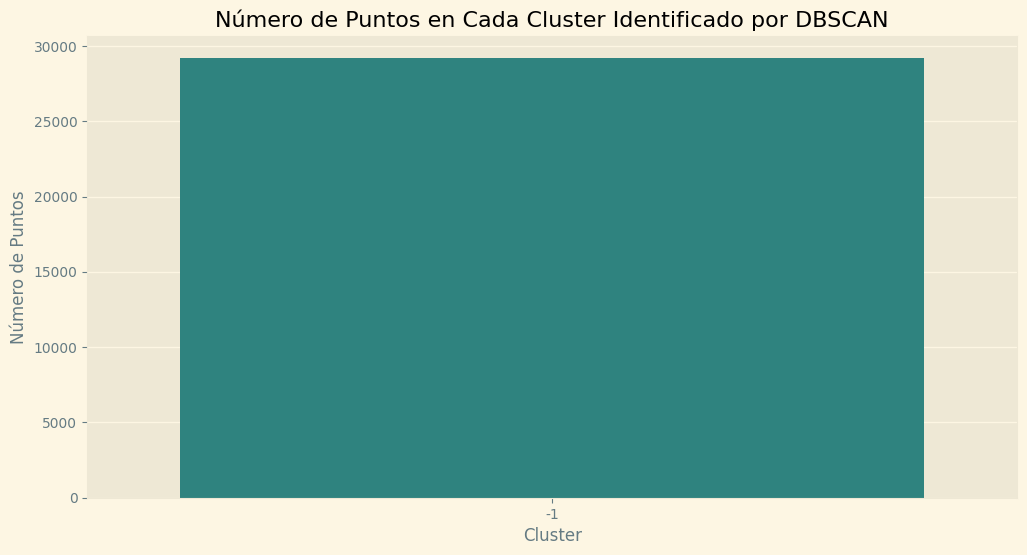

In [ ]:
# Visualización de la cantidad de puntos en cada cluster
unique, counts = np.unique(clusters, return_counts=True)
cluster_counts = dict(zip(unique, counts))

plt.figure(figsize=(12, 6))
sns.barplot(x=list(cluster_counts.keys()), y=list(cluster_counts.values()), palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Número de Puntos')
plt.title('Número de Puntos en Cada Cluster Identificado por DBSCAN')
plt.show()

In [ ]:
# Crear una matriz de distancias entre clusters si es relevante
'''
distance_matrix = pairwise_distances(pca_df, pca_df, metric='euclidean')

plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, cmap='viridis')
plt.title('Matriz de Distancias Euclidianas entre Puntos')
plt.show()
'''


"\ndistance_matrix = pairwise_distances(pca_df, pca_df, metric='euclidean')\n\nplt.figure(figsize=(10, 8))\nsns.heatmap(distance_matrix, cmap='viridis')\nplt.title('Matriz de Distancias Euclidianas entre Puntos')\nplt.show()\n"